<a href="https://colab.research.google.com/github/ritesh-tiwary/ineuron/blob/main/python_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Code

In [ ]:
streamLogger/config.py

import os

# Statement for enabling the development environment
DEBUG = True

# Define the application directory
BASE_DIR = os.path.abspath(os.path.dirname(__file__))

# Application threads. A common general assumption is
# using 2 per available processor cores - to handle
# incoming requests using one and performing background
# operations using the other.
THREADS_PER_PAGE = 2

# Enable protection against *Cross-site Request Forgery (CSRF)*
CSRF_ENABLED = True

# Use a secure, unique and absolutely secret key for
# signing the data.
CSRF_SESSION_KEY = "secret"



In [ ]:
streamLogger/run.py
# Run a test server.
from app import app
app.run(host='0.0.0.0', port=3000, debug=True)



In [ ]:
app/__init__.py

import json
from datetime import datetime, date
from flask import Flask, request, render_template

# Define the WSGI application object
app = Flask(__name__)

# Configurations
app.config.from_object('config')

d = date.today().strftime("%d-%b-%Y")
y = date.today().strftime("%Y")


@app.route('/')
def index():
    try:
        with open("app/logs/".__add__(y).__add__("/").__add__(d).__add__(".json")) as f:
            data = json.load(f)
    except FileNotFoundError:
        data = []
    return render_template('index.html', data=data, utc_dt=datetime.utcnow())


@app.route("/logs", methods=["post"])
def logs():
    try:
        logs = []
        log = request.data
        with open("app/logs/".__add__(y).__add__("/").__add__(d).__add__(".json")) as f:
            logs = json.load(f)
        logs.append(json.loads(log))
        with open("app/logs/".__add__(y).__add__("/").__add__(d).__add__(".json"), "w") as f:
            json.dump(logs, f, indent=4, separators=(',', ': '))
    except FileNotFoundError:
        logs.append(json.loads(log))
        with open("app/logs/".__add__(y).__add__("/").__add__(d).__add__(".json"), "w") as f:
            json.dump(logs, f, indent=4, separators=(',', ': '))
    return "OK", 200


# Sample HTTP error handling
@app.errorhandler(404)
def not_found(error):
    return render_template('404.html'), 404



In [ ]:
streamLogger/streamLogger.py

import json
import logging
import requests

class RequestsHandler(logging.Handler):
    def emit(self, record):
        log = self.format(record)
        # response = requests.post('http://localhost:3000/logs', headers={"Content-type": "application/json"}, data=log)
        # print("Status Code", response.status_code)
        print(log)
        return requests.post('http://localhost:3000/logs',
                             headers={"Content-type": "application/json"},
                             data=log).content


class FormatterLogger(logging.Formatter):
    def __init__(self, task_name=None):
        super(FormatterLogger, self).__init__()

    def format(self, record):
        data = {'@message': record.msg,
                '@funcName': record.funcName,
                '@exc_text': record.exc_text,
                '@lineno': 0 if record.exc_text is None else record.lineno,
                '@exc_info': record.exc_info,
                }

        return json.dumps(data)


def custom_logger(name):
    logger = logging.getLogger(name)
    custom_handler = RequestsHandler()
    formatter = FormatterLogger(logger)
    custom_handler.setFormatter(formatter)
    logger.addHandler(custom_handler)
    return logger


logger = custom_logger("ECA")
logger.exception("ECA - Job Failed")
logger.exception("ECA - Job Completed Successfully")


In [ ]:
streamLogger/app/templates/index.html

{% extends 'base.html' %}

{% block content %}
<!--    <h1>{% block title %} Index {% endblock %}</h1>-->
<!--    <h1>Hello World!</h1>-->
<!--    <h2>Welcome to FlaskApp!</h2>-->
    <h3 style="margin-left: 20px;">UTC Time: {{ utc_dt }}</h3>
    <div style="width: 100%; margin: auto">
        <div style="display: flex; padding: 10px; background-color: #e7f9ff; margin: 20px">
            <div style="width: 25%; display: inline-block; font-weight: bold;><p style="font-size: 100px"> Message </p></div>
            <div style="width: 20%; display: inline-block; font-weight: bold;><p style="font-size: 32px"> Method Name </p></div>
            <div style="width: 20%; display: inline-block; font-weight: bold;><p style="font-size: 32px"> Exception Text </p></div>
            <div style="width: 10%; display: inline-block; font-weight: bold;><p style="font-size: 32px"> Line No </p></div>
            <div style="width: 25%; display: inline-block; font-weight: bold;><p style="font-size: 32px"> Traceback </p></div>
        </div>
        {% for d in data %}
            {% if loop.index % 2 == 0 %}
                    {% set bg_color = '#e6f9ff' %}
                {% else %}
                    {% set bg_color = '#eee' %}
                {% endif %}

                <div style="display: flex; padding: 10px; background-color: {{ bg_color }}; margin: 20px">
                    <div style="width: 25%; display: inline-block;><p style="font-size: 24px"> {{ d["@message"] }} </p></div>
                    <div style="width: 20%; display: inline-block;><p style="font-size: 24px"> {{ d["@funcName"] }} </p></div>
                    <div style="width: 20%; display: inline-block;><p style="font-size: 24px"> {{ d["@exc_text"] }} </p></div>
                    <div style="width: 10%; display: inline-block;><p style="font-size: 24px"> {{ d["@lineno"] }}   </p></div>
                    <div style="width: 25%; display: inline-block;><p style="font-size: 24px"> {{ d["@exc_info"] }} </p></div>
                </div>
        {% endfor %}
    </div>
{% endblock %}



In [ ]:
streamLogger/app/templates/base.html

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>{% block title %} {% endblock %} - FlaskApp</title>
    <style>
        nav a {
            color: #d64161;
            font-size: 3em;
            margin-left: 20px;
            text-decoration: none;
        }
    </style>
</head>
<body>
    <nav>
        <a href="#">C D R&nbsp;&nbsp;J O B&nbsp;&nbsp;D A S H B O A R D</a>
    </nav>
    <hr>
    <div class="content">
        {% block content %} {% endblock %}
    </div>
</body>
</html>

In [ ]:
streamLogger/app/templates/404.html

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>404</title>
</head>
<body>

</body>
</html>

In [ ]:
streamLogger/app/logs/2022/23-Jun-2022.json

[Amazon S3 code examples for the SDK for Python](https://github.com/awsdocs/aws-doc-sdk-examples/tree/main/python/example_code/s3/s3_basics#code-examples)

In [ ]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Purpose
Show how to use AWS SDK for Python (Boto3) with Amazon Simple Storage Service
(Amazon S3) to perform basic object operations
"""

import json
import logging
import random
import uuid

import boto3
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)


# snippet-start:[python.example_code.s3.helper.ObjectWrapper]
class ObjectWrapper:
    """Encapsulates S3 object actions."""
    def __init__(self, s3_object):
        """
        :param s3_object: A Boto3 Object resource. This is a high-level resource in Boto3
                          that wraps object actions in a class-like structure.
        """
        self.object = s3_object
        self.key = self.object.key
# snippet-end:[python.example_code.s3.helper.ObjectWrapper]

# snippet-start:[python.example_code.s3.PutObject]
    def put(self, data):
        """
        Upload data to the object.
        :param data: The data to upload. This can either be bytes or a string. When this
                     argument is a string, it is interpreted as a file name, which is
                     opened in read bytes mode.
        """
        put_data = data
        if isinstance(data, str):
            try:
                put_data = open(data, 'rb')
            except IOError:
                logger.exception("Expected file name or binary data, got '%s'.", data)
                raise

        try:
            self.object.put(Body=put_data)
            self.object.wait_until_exists()
            logger.info(
                "Put object '%s' to bucket '%s'.", self.object.key,
                self.object.bucket_name)
        except ClientError:
            logger.exception(
                "Couldn't put object '%s' to bucket '%s'.", self.object.key,
                self.object.bucket_name)
            raise
        finally:
            if getattr(put_data, 'close', None):
                put_data.close()
# snippet-end:[python.example_code.s3.PutObject]

# snippet-start:[python.example_code.s3.GetObject]
    def get(self):
        """
        Gets the object.
        :return: The object data in bytes.
        """
        try:
            body = self.object.get()['Body'].read()
            logger.info(
                "Got object '%s' from bucket '%s'.",
                self.object.key, self.object.bucket_name)
        except ClientError:
            logger.exception(
                "Couldn't get object '%s' from bucket '%s'.",
                self.object.key, self.object.bucket_name)
            raise
        else:
            return body
# snippet-end:[python.example_code.s3.GetObject]

# snippet-start:[python.example_code.s3.ListObjects]
    @staticmethod
    def list(bucket, prefix=None):
        """
        Lists the objects in a bucket, optionally filtered by a prefix.
        :param bucket: The bucket to query. This is a Boto3 Bucket resource.
        :param prefix: When specified, only objects that start with this prefix are listed.
        :return: The list of objects.
        """
        try:
            if not prefix:
                objects = list(bucket.objects.all())
            else:
                objects = list(bucket.objects.filter(Prefix=prefix))
            logger.info("Got objects %s from bucket '%s'",
                        [o.key for o in objects], bucket.name)
        except ClientError:
            logger.exception("Couldn't get objects for bucket '%s'.", bucket.name)
            raise
        else:
            return objects
# snippet-end:[python.example_code.s3.ListObjects]

# snippet-start:[python.example_code.s3.CopyObject]
    def copy(self, dest_object):
        """
        Copies the object to another bucket.
        :param dest_object: The destination object initialized with a bucket and key.
                            This is a Boto3 Object resource.
        """
        try:
            dest_object.copy_from(CopySource={
                'Bucket': self.object.bucket_name,
                'Key': self.object.key
            })
            dest_object.wait_until_exists()
            logger.info(
                "Copied object from %s:%s to %s:%s.",
                self.object.bucket_name, self.object.key,
                dest_object.bucket_name, dest_object.key)
        except ClientError:
            logger.exception(
                "Couldn't copy object from %s/%s to %s/%s.",
                self.object.bucket_name, self.object.key,
                dest_object.bucket_name, dest_object.key)
            raise
# snippet-end:[python.example_code.s3.CopyObject]

# snippet-start:[python.example_code.s3.DeleteObject]
    def delete(self):
        """
        Deletes the object.
        """
        try:
            self.object.delete()
            self.object.wait_until_not_exists()
            logger.info(
                "Deleted object '%s' from bucket '%s'.",
                self.object.key, self.object.bucket_name)
        except ClientError:
            logger.exception(
                "Couldn't delete object '%s' from bucket '%s'.",
                self.object.key, self.object.bucket_name)
            raise
# snippet-end:[python.example_code.s3.DeleteObject]

# snippet-start:[python.example_code.s3.DeleteObjects_Keys]
    @staticmethod
    def delete_objects(bucket, object_keys):
        """
        Removes a list of objects from a bucket.
        This operation is done as a batch in a single request.
        :param bucket: The bucket that contains the objects. This is a Boto3 Bucket
                       resource.
        :param object_keys: The list of keys that identify the objects to remove.
        :return: The response that contains data about which objects were deleted
                 and any that could not be deleted.
        """
        try:
            response = bucket.delete_objects(Delete={
                'Objects': [{
                    'Key': key
                } for key in object_keys]
            })
            if 'Deleted' in response:
                logger.info(
                    "Deleted objects '%s' from bucket '%s'.",
                    [del_obj['Key'] for del_obj in response['Deleted']], bucket.name)
            if 'Errors' in response:
                logger.warning(
                    "Could not delete objects '%s' from bucket '%s'.", [
                        f"{del_obj['Key']}: {del_obj['Code']}"
                        for del_obj in response['Errors']],
                    bucket.name)
        except ClientError:
            logger.exception("Couldn't delete any objects from bucket %s.", bucket.name)
            raise
        else:
            return response
# snippet-end:[python.example_code.s3.DeleteObjects_Keys]

# snippet-start:[python.example_code.s3.DeleteObjects_All]
    @staticmethod
    def empty_bucket(bucket):
        """
        Remove all objects from a bucket.
        :param bucket: The bucket to empty. This is a Boto3 Bucket resource.
        """
        try:
            bucket.objects.delete()
            logger.info("Emptied bucket '%s'.", bucket.name)
        except ClientError:
            logger.exception("Couldn't empty bucket '%s'.", bucket.name)
            raise
# snippet-end:[python.example_code.s3.DeleteObjects_All]

# snippet-start:[python.example_code.s3.PutObjectAcl]
    def put_acl(self, email):
        """
        Applies an ACL to the object that grants read access to an AWS user identified
        by email address.
        :param email: The email address of the user to grant access.
        """
        try:
            acl = self.object.Acl()
            # Putting an ACL overwrites the existing ACL, so append new grants
            # if you want to preserve existing grants.
            grants = acl.grants if acl.grants else []
            grants.append({
                'Grantee': {
                    'Type': 'AmazonCustomerByEmail',
                    'EmailAddress': email
                },
                'Permission': 'READ'
            })
            acl.put(
                AccessControlPolicy={
                    'Grants': grants,
                    'Owner': acl.owner
                }
            )
            logger.info("Granted read access to %s.", email)
        except ClientError:
            logger.exception("Couldn't add ACL to object '%s'.", self.object.key)
            raise
# snippet-end:[python.example_code.s3.PutObjectAcl]

# snippet-start:[python.example_code.s3.GetObjectAcl]
    def get_acl(self):
        """
        Gets the ACL of the object.
        :return: The ACL of the object.
        """
        try:
            acl = self.object.Acl()
            logger.info(
                "Got ACL for object %s owned by %s.",
                self.object.key, acl.owner['DisplayName'])
        except ClientError:
            logger.exception("Couldn't get ACL for object %s.", self.object.key)
            raise
        else:
            return acl
# snippet-end:[python.example_code.s3.GetObjectAcl]


# snippet-start:[python.example_code.s3.Scenario_ObjectManagement]
def usage_demo():
    print('-'*88)
    print("Welcome to the Amazon S3 object demo!")
    print('-'*88)

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(f'doc-example-bucket-{uuid.uuid4()}')
    try:
        bucket.create(
            CreateBucketConfiguration={
                'LocationConstraint': s3_resource.meta.client.meta.region_name})
    except ClientError as err:
        print(
            f"Couldn't create a bucket for the demo. Here's why: "
            f"{err.response['Error']['Message']}.")

    object_key = 'doc-example-object'
    obj_wrapper = ObjectWrapper(bucket.Object(object_key))
    obj_wrapper.put(__file__)
    print(f"Put file object with key {object_key} in bucket {bucket.name}.")

    with open(__file__) as file:
        lines = file.readlines()

    line_wrappers = []
    for _ in range(10):
        line = random.randint(0, len(lines))
        line_wrapper = ObjectWrapper(bucket.Object(f'line-{line}'))
        line_wrapper.put(bytes(lines[line], 'utf-8'))
        line_wrappers.append(line_wrapper)
    print(f"Put 10 random lines from this script as objects.")

    listed_lines = ObjectWrapper.list(bucket, 'line-')
    print(f"Their keys are: {', '.join(l.key for l in listed_lines)}")

    line = line_wrappers.pop()
    line_body = line.get()
    print(f"Got object with key {line.key} and body {line_body}.")
    line.delete()
    print(f"Deleted object with key {line.key}.")

    copied_obj = bucket.Object(line_wrappers[0].key + '-copy')
    line_wrappers[0].copy(copied_obj)
    print(f"Made a copy of object {line_wrappers[0].key}, named {copied_obj.key}.")

    try:
        obj_wrapper.put_acl('arnav@example.net')
        acl = obj_wrapper.get_acl()
        print(f"Put ACL grants on object {obj_wrapper.key}: {json.dumps(acl.grants)}")
    except ClientError as error:
        if error.response['Error']['Code'] == 'UnresolvableGrantByEmailAddress':
            print('*'*88)
            print("This demo couldn't apply the ACL to the object because the email\n"
                  "address specified as the grantee is for a test user who does not\n"
                  "exist. For this request to succeed, you must replace the grantee\n"
                  "email with one for an existing AWS user.")
            print('*' * 88)
        else:
            raise

    ObjectWrapper.empty_bucket(bucket)
    print(f"Emptied bucket {bucket.name} in preparation for deleting it.")

    bucket.delete()
    print(f"Deleted bucket {bucket.name}.")
    print("Thanks for watching!")
    print('-'*88)
# snippet-end:[python.example_code.s3.Scenario_ObjectManagement]


if __name__ == '__main__':
    usage_demo()


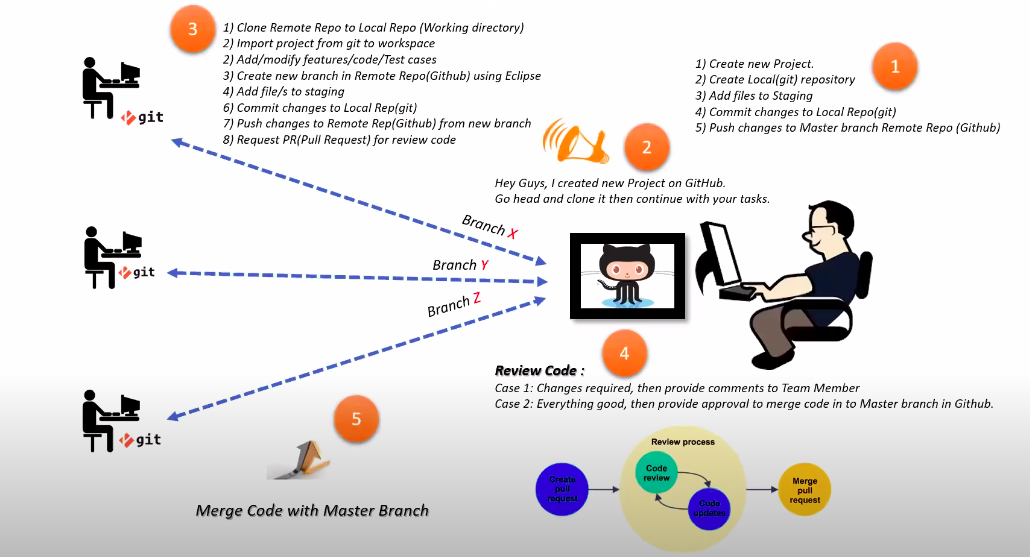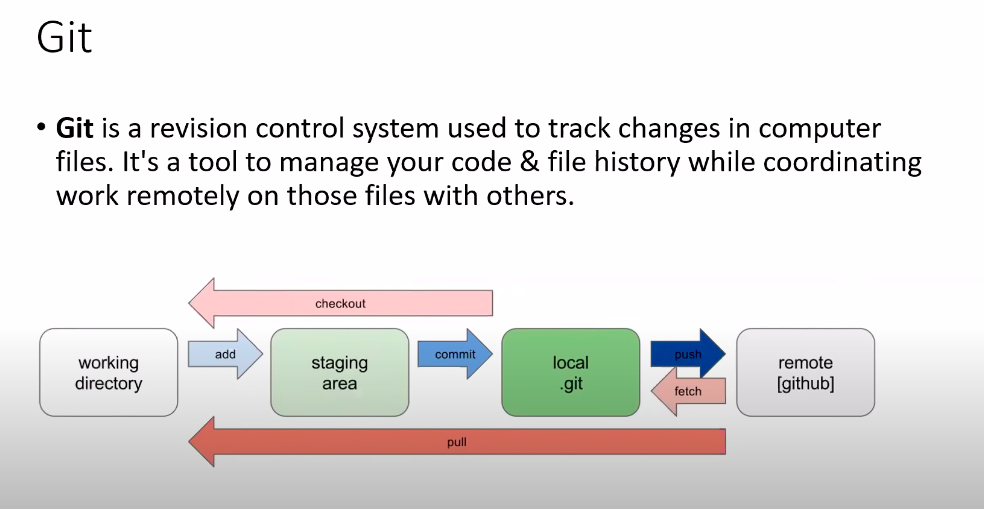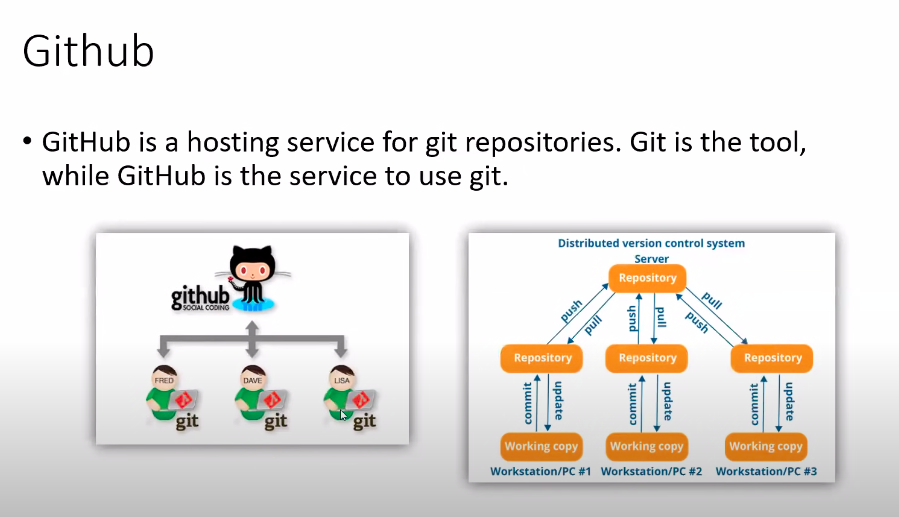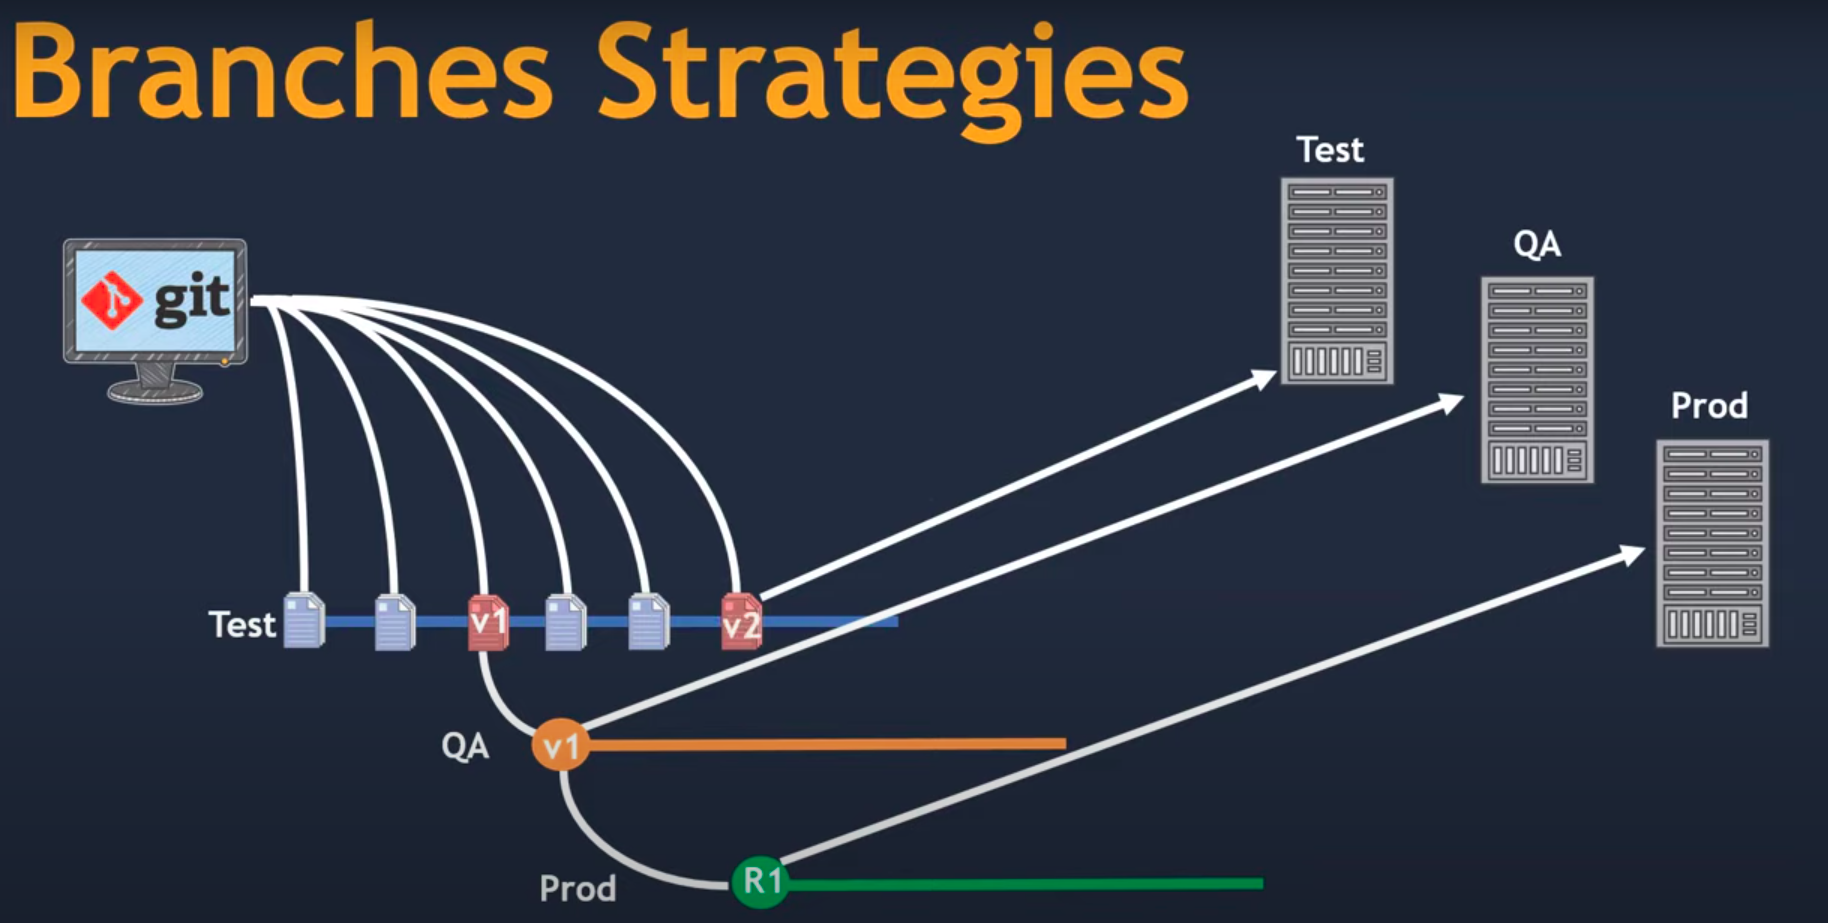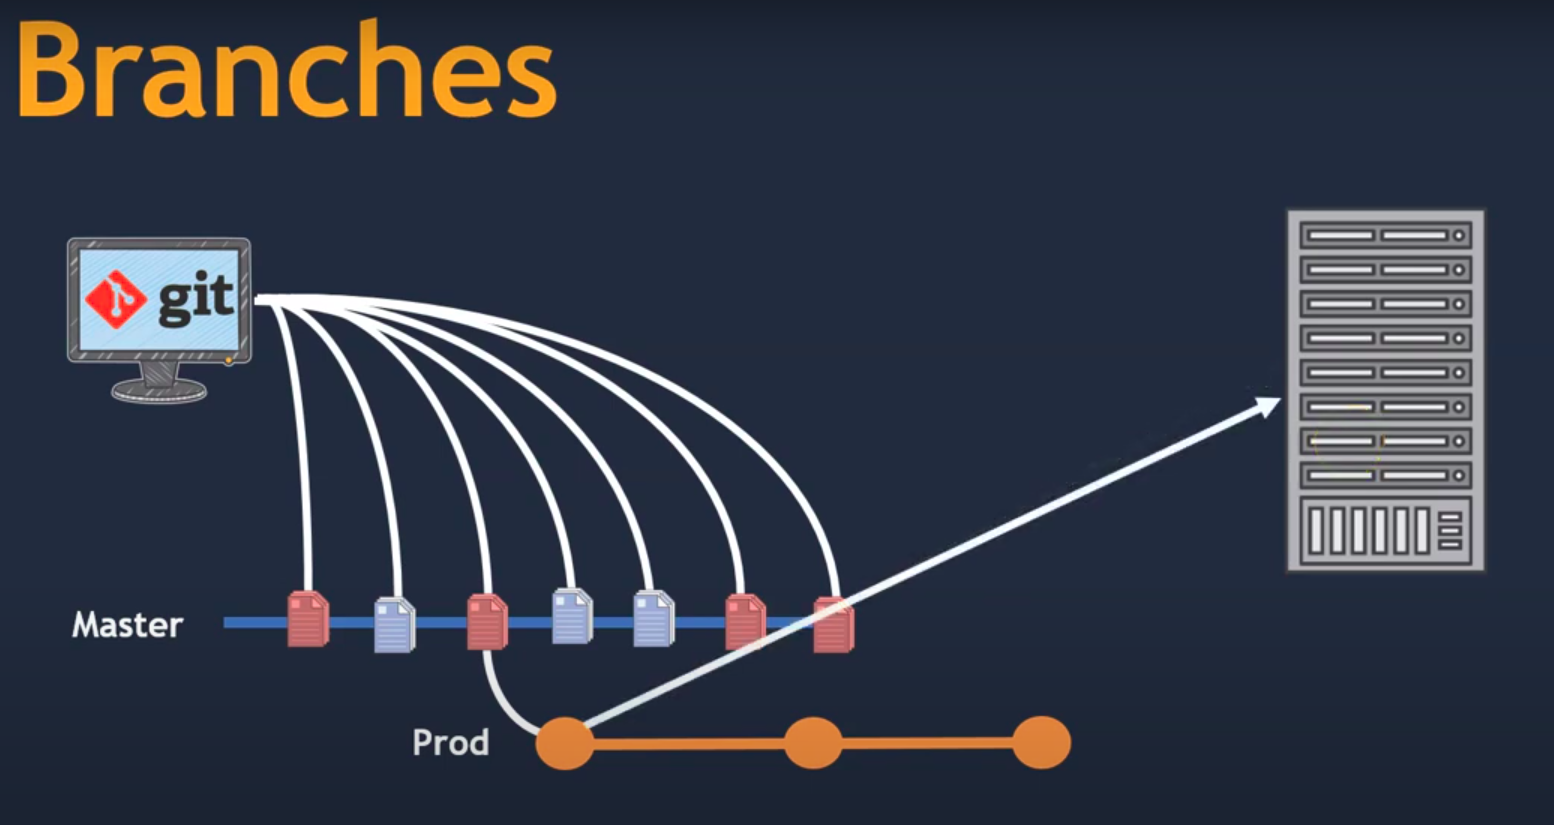

In [ ]:
class DatabaseManager:
    def __init__(self):
        self.databases = {}

    def add_database(self, name, db_instance):
        self.databases[name] = db_instance

    def connect(self, name):
        if name in self.databases:
            self.databases[name].connect()
        else:
            print("Database not found.")

    def disconnect(self, name):
        if name in self.databases:
            self.databases[name].disconnect()
        else:
            print("Database not found.")


""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
class OracleDB:
    def __init__(self, username, password, host, port, service_name):
        self.username = username
        self.password = password
        self.host = host
        self.port = port
        self.service_name = service_name
        self.connection = None

    def connect(self):
        dsn = cx_Oracle.makedsn(self.host, self.port, service_name=self.service_name)
        self.connection = cx_Oracle.connect(self.username, self.password, dsn)
        print("Connected to Oracle Database")

    def disconnect(self):
        if self.connection:
            self.connection.close()
            print("Disconnected from Oracle Database")

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
class PostgresDB:
    def __init__(self, username, password, host, port, database):
        self.username = username
        self.password = password
        self.host = host
        self.port = port
        self.database = database
        self.connection = None

    def connect(self):
        conn_string = f"host={self.host} port={self.port} dbname={self.database} user={self.username} password={self.password}"
        self.connection = psycopg2.connect(conn_string)
        print("Connected to PostgreSQL Database")

    def disconnect(self):
        if self.connection:
            self.connection.close()
            print("Disconnected from PostgreSQL Database")
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if __name__ == "__main__":
    db_manager = DatabaseManager()

    oracle_db = OracleDB(
        username="oracle_user",
        password="oracle_password",
        host="oracle_host",
        port="oracle_port",
        service_name="oracle_service_name"
    )

    postgres_db = PostgresDB(
        username="postgres_user",
        password="postgres_password",
        host="postgres_host",
        port="postgres_port",
        database="postgres_database"
    )

    db_manager.add_database("oracle", oracle_db)
    db_manager.add_database("postgres", postgres_db)

    db_manager.connect("oracle")
    # Perform Oracle-specific operations using the oracle_db instance
    db_manager.disconnect("oracle")

    db_manager.connect("postgres")
    # Perform PostgreSQL-specific operations using the postgres_db instance
    db_manager.disconnect("postgres")


```
index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>CSV to XLSX Converter</title>
</head>
<body>
    <h1>CSV to XLSX Converter</h1>
    <form action="/convert" method="post" enctype="multipart/form-data">
        <input type="file" name="csv_file" accept=".csv">
        <input type="submit" value="Convert">
    </form>
    <progress id="progress" max="100" value="0"></progress>
    <div id="status">Status: Waiting</div>
    <div id="download_link" style="display:none">
        <a href=""></a>
    </div>
    <script>
        const form = document.querySelector('form');
        const progress = document.getElementById('progress');
        const status = document.getElementById('status');
        const downloadLink = document.getElementById('download_link');

        form.addEventListener('submit', (event) => {
            event.preventDefault();

            const formData = new FormData(form);
            const xhr = new XMLHttpRequest();

            xhr.upload.addEventListener('progress', (e) => {
                if (e.lengthComputable) {
                    const percentComplete = (e.loaded / e.total) * 100;
                    progress.value = percentComplete;
                    status.innerText = `Status: Converting (${percentComplete.toFixed(2)}%)`;
                }
            });

            xhr.onreadystatechange = () => {
                if (xhr.readyState === 4 && xhr.status === 200) {
                    const response = JSON.parse(xhr.responseText);
                    if (response.status === 'success') {
                        downloadLink.style.display = 'block';
                        downloadLink.querySelector('a').href = response.download_url;
                        downloadLink.querySelector('a').innerText = 'Download XLSX';
                        status.innerText = 'Status: Conversion complete';
                    } else {
                        status.innerText = 'Status: Conversion failed';
                    }
                }
            };

            xhr.open('POST', '/convert', true);
            xhr.send(formData);
        });
    </script>
</body>
</html>
```

In [ ]:


app.py
import os
from flask import Flask, render_template, request, jsonify

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'converted_files'
app.config['ALLOWED_EXTENSIONS'] = {'csv'}

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/convert', methods=['POST'])
def convert():
    if 'csv_file' not in request.files:
        return jsonify({'status': 'error', 'message': 'No file part'})

    file = request.files['csv_file']

    if file.filename == '':
        return jsonify({'status': 'error', 'message': 'No selected file'})

    if file and allowed_file(file.filename):
        # Save the CSV file to the server
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], file.filename)
        file.save(filepath)

        # Convert the CSV file to XLSX
        # You can use a library like openpyxl or pandas to perform the conversion
        # Replace the following line with your actual conversion code
        # For example:
        # convert_csv_to_xlsx(filepath, os.path.join(app.config['UPLOAD_FOLDER'], 'output.xlsx'))

        # Simulate a delay for demonstration purposes (you can remove this in production)
        import time
        for i in range(101):
            time.sleep(0.05)
            yield f"data:{i}\n\n"

        # Return the download URL for the converted XLSX file
        download_url = f"/{app.config['UPLOAD_FOLDER']}/{file.filename.split('.')[0]}.xlsx"
        return jsonify({'status': 'success', 'download_url': download_url})

    else:
        return jsonify({'status': 'error', 'message': 'Invalid file format'})

if __name__ == '__main__':
    app.run(debug=True)
